# Time Series Forecasting

## Extraction

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/conv_data.csv')
df

,timestamp,hourly average,usage,hour,day_of_week
0,2024-02-01 00:00:00,1.955991e+07,0.000000,0,3
1,2024-02-01 01:00:00,1.956011e+07,0.199500,1,3
2,2024-02-01 02:00:00,1.956033e+07,0.220500,2,3
3,2024-02-01 03:00:00,1.956056e+07,0.225000,3,3
4,2024-02-01 04:00:00,1.956076e+07,0.204500,4,3
...,...,...,...,...,...
4472,2024-08-28 09:00:00,4.186957e+07,13.110667,9,2
4473,2024-08-28 10:00:00,4.189131e+07,21.741000,10,2
4474,2024-08-28 11:00:00,4.190912e+07,17.805583,11,2
4475,2024-08-28 12:00:00,4.192575e+07,16.629350,12,2


In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [4]:
df.drop(columns=['day_of_week'], inplace=True)

In [5]:
missing_values = df.isnull().sum()
missing_values


hourly average    0
usage             0
hour              0
dtype: int64

In [6]:
df['year'] = df.index.year
df['month'] = df.index.month
df['week'] = df.index.isocalendar().week
df['weekday'] = df.index.weekday 
df['hour'] = df.index.hour

In [7]:
df

,hourly average,usage,hour,year,month,week,weekday
timestamp,,,,,,,
2024-02-01 00:00:00,1.955991e+07,0.000000,0,2024,2,5,3
2024-02-01 01:00:00,1.956011e+07,0.199500,1,2024,2,5,3
2024-02-01 02:00:00,1.956033e+07,0.220500,2,2024,2,5,3
2024-02-01 03:00:00,1.956056e+07,0.225000,3,2024,2,5,3
2024-02-01 04:00:00,1.956076e+07,0.204500,4,2024,2,5,3
...,...,...,...,...,...,...,...
2024-08-28 09:00:00,4.186957e+07,13.110667,9,2024,8,35,2
2024-08-28 10:00:00,4.189131e+07,21.741000,10,2024,8,35,2
2024-08-28 11:00:00,4.190912e+07,17.805583,11,2024,8,35,2


## EDA

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

Overall Usage

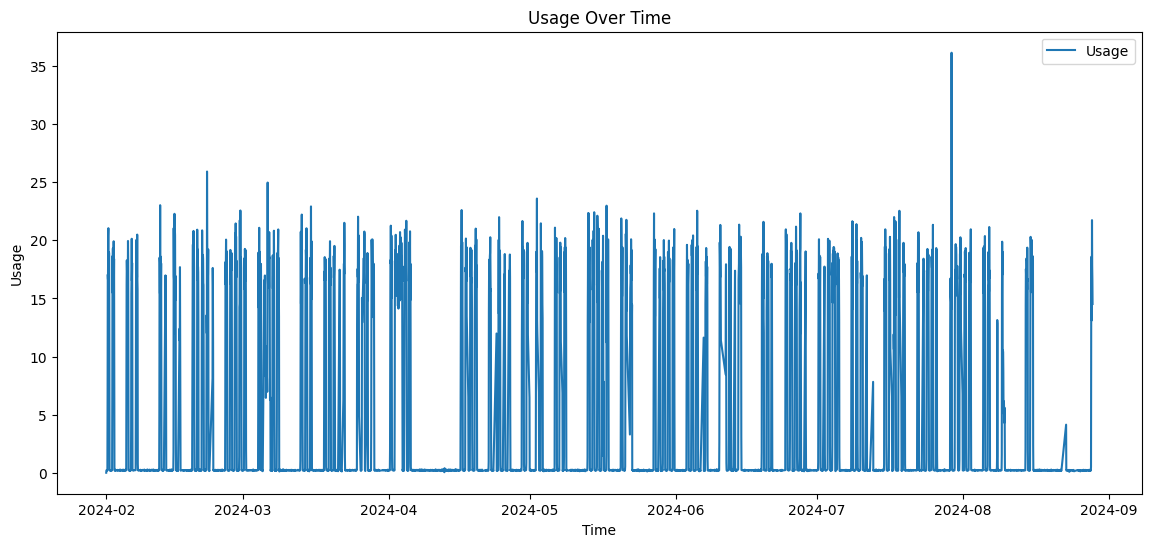

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['usage'], label='Usage')
plt.title('Usage Over Time')
plt.xlabel('Time')
plt.ylabel('Usage')
plt.legend()
plt.show()

Daily Patterns

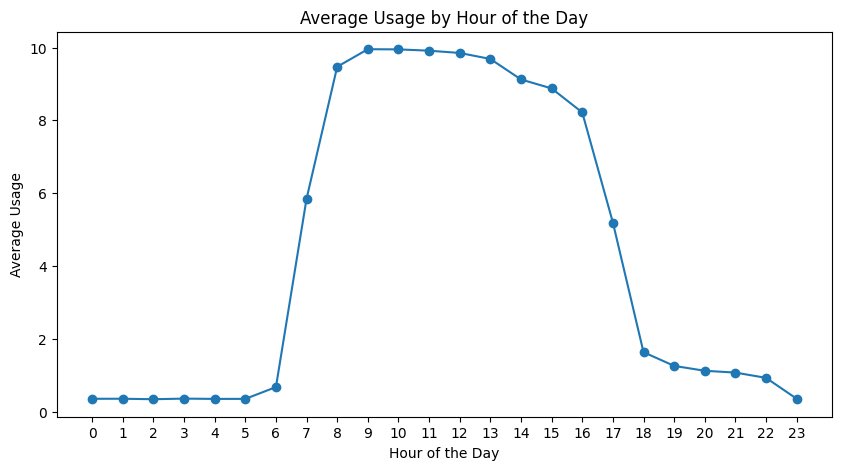

In [10]:
hourly_usage = df.groupby('hour')['usage'].mean()
plt.figure(figsize=(10, 5))
plt.plot(hourly_usage, marker='o')
plt.title('Average Usage by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Usage')
plt.xticks(range(0, 24))
plt.show()

Weekly Pattern

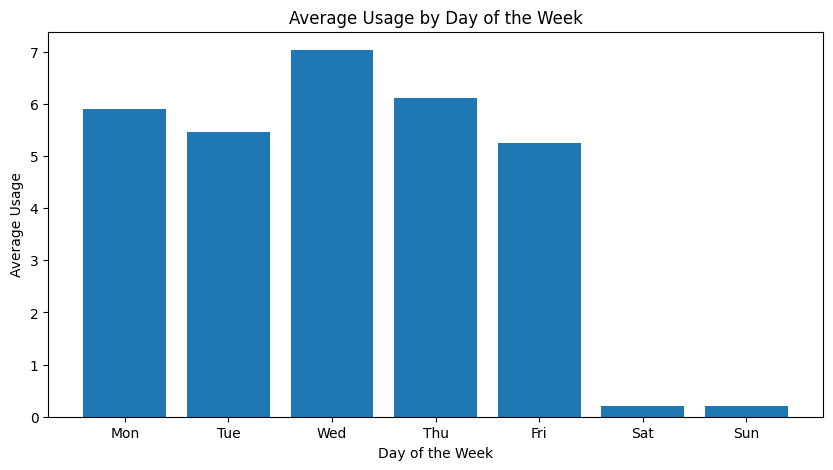

In [11]:
weekday_usage = df.groupby('weekday')['usage'].mean()
plt.figure(figsize=(10, 5))
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], weekday_usage)
plt.title('Average Usage by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Usage')
plt.show()

Monthly Pattern

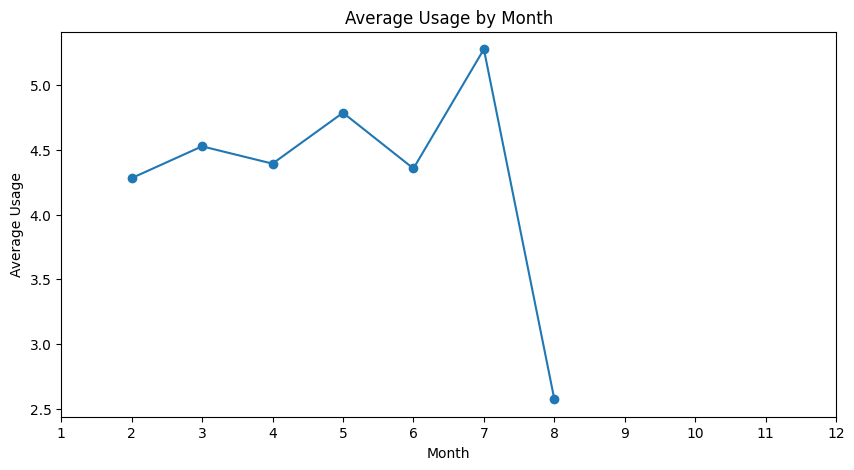

In [12]:
monthly_usage = df.groupby('month')['usage'].mean()
plt.figure(figsize=(10, 5))
plt.plot(monthly_usage, marker='o')
plt.title('Average Usage by Month')
plt.xlabel('Month')
plt.ylabel('Average Usage')
plt.xticks(range(1, 13))
plt.show()

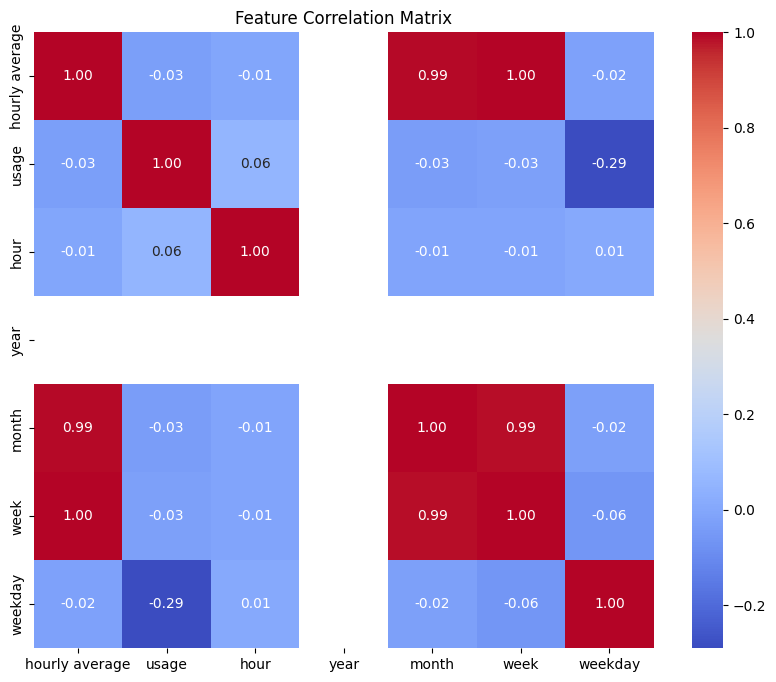

In [13]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

Stationarity check

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
adf_test = adfuller(df['usage'])
adf_statistic = adf_test[0]
p_value = adf_test[1]

adf_statistic, p_value

(-9.713554084220005, 9.967368002682916e-17)

Since the p-value is significantly less than 0.05, we can reject the null hypothesis and conclude that the data is stationary. Thus, the data is suitable for modeling

## Modelling (LSTM)

In [16]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf

In [17]:
sequence_length = 24 

scaler = MinMaxScaler(feature_range=(0, 1))
df['usage_scaled'] = scaler.fit_transform(df[['usage']])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)


In [18]:
X, y = create_sequences(df['usage_scaled'].values, sequence_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [19]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3562, 24, 1), (3562,), (891, 24, 1), (891,))

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='relu')
])

model.compile(optimizer='adam', loss='mse')

C:\Users\62813\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0376 - val_loss: 0.0133
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0170 - val_loss: 0.0106
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0142 - val_loss: 0.0097
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0142 - val_loss: 0.0086
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0129 - val_loss: 0.0084
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0127 - val_loss: 0.0080
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0117 - val_loss: 0.0076
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0112 - val_loss: 0.0071
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0103 - val_loss: 0.0068
Epoch 10/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0103 - val_loss: 0.0071
Epoch 11/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0103 - val_loss: 0.0066
Epoch 12/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 

## Evaluate

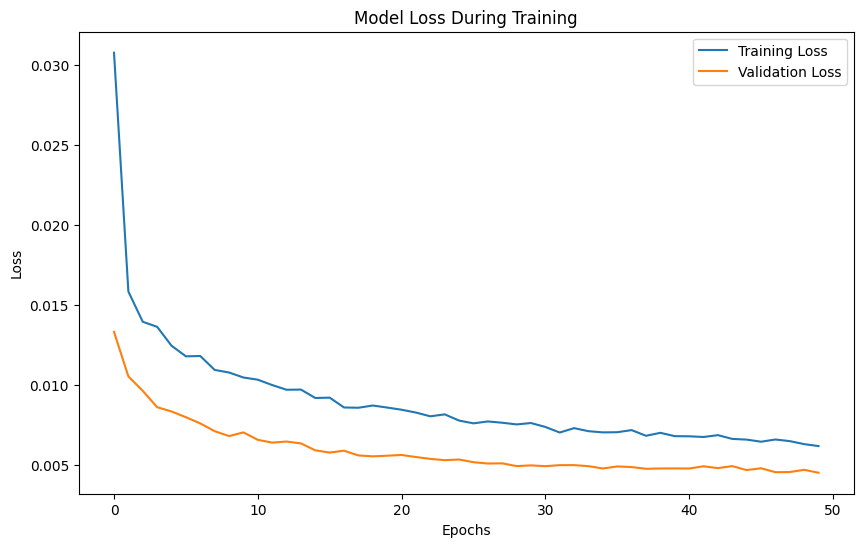

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


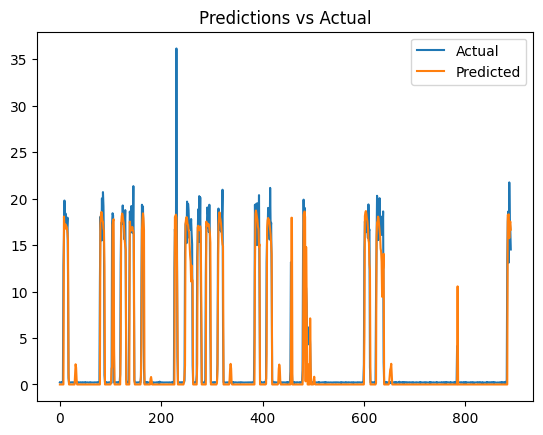

In [24]:
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.title('Predictions vs Actual')
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [26]:
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = math.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Squared Error (MSE): 5.9271
Mean Absolute Error (MAE): 0.9662
Root Mean Squared Error (RMSE): 2.4346


In [27]:
start_date = '2024-03-20 00:00:00'  
end_date = '2024-03-25 23:59:59'    

week_indices = (df.index >= start_date) & (df.index <= end_date)
week_data = df[week_indices]

X_week, y_week = create_sequences(week_data['usage_scaled'].values, sequence_length)
X_week = X_week.reshape((X_week.shape[0], X_week.shape[1], 1))

predictions_week = model.predict(X_week)
predictions_week = scaler.inverse_transform(predictions_week)
y_week = scaler.inverse_transform(y_week.reshape(-1, 1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [28]:
import matplotlib.dates as mdates

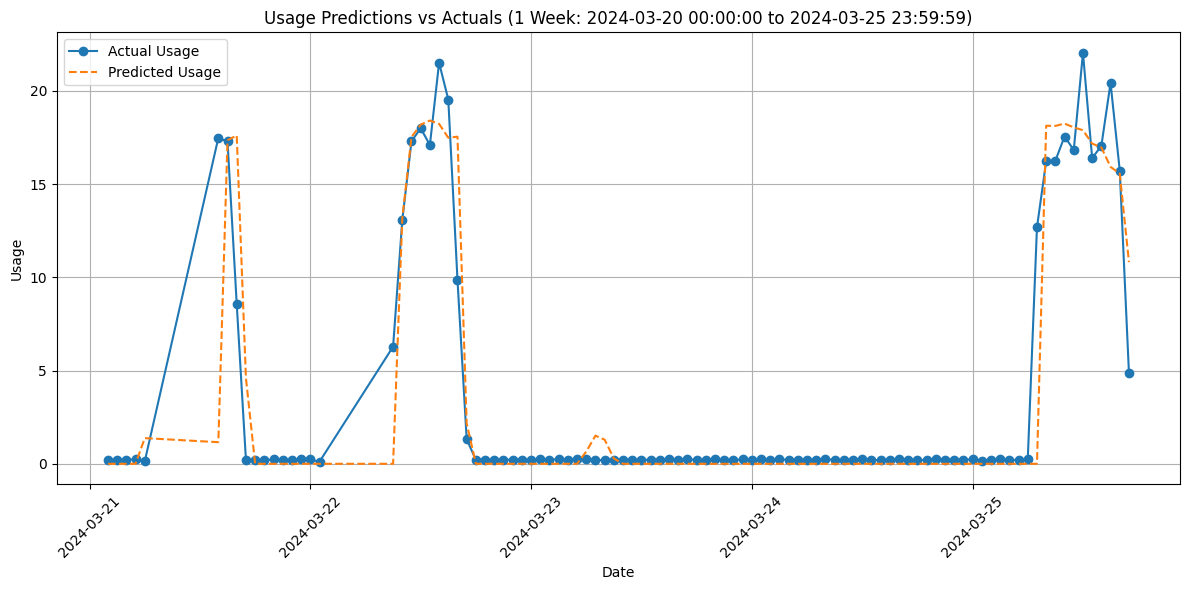

In [29]:
plt.figure(figsize=(12, 6))

plt.plot(week_data.index[sequence_length:], y_week, label='Actual Usage', marker='o')
plt.plot(week_data.index[sequence_length:], predictions_week, label='Predicted Usage', linestyle='--')

# Format sumbu x agar sesuai dengan per hari
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())

plt.title(f'Usage Predictions vs Actuals (1 Week: {start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Usage')
plt.legend()
plt.grid()
plt.xticks(rotation=45)  
plt.tight_layout() 
plt.show()

In [30]:
full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')

df = df.reindex(full_time_range)

df.reset_index(inplace=True)
df.rename(columns={'index': 'timestamp'}, inplace=True)

print(f"Jumlah nilai NaN di 'usage': {df['usage'].isna().sum()}")

df.head(10)

Jumlah nilai NaN di 'usage': 553


C:\Users\62813\AppData\Local\Temp\ipykernel_11544\1763490669.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')


,timestamp,hourly average,usage,hour,year,month,week,weekday,usage_scaled
0,2024-02-01 00:00:00,1.955991e+07,0.000000,0.0,2024.0,2.0,5,3.0,0.000000
1,2024-02-01 01:00:00,1.956011e+07,0.199500,1.0,2024.0,2.0,5,3.0,0.005519
2,2024-02-01 02:00:00,1.956033e+07,0.220500,2.0,2024.0,2.0,5,3.0,0.006099
3,2024-02-01 03:00:00,1.956056e+07,0.225000,3.0,2024.0,2.0,5,3.0,0.006224
4,2024-02-01 04:00:00,1.956076e+07,0.204500,4.0,2024.0,2.0,5,3.0,0.005657
5,2024-02-01 05:00:00,1.956099e+07,0.234100,5.0,2024.0,2.0,5,3.0,0.006476
6,2024-02-01 06:00:00,1.956119e+07,0.197400,6.0,2024.0,2.0,5,3.0,0.005460
7,2024-02-01 07:00:00,1.956787e+07,6.675750,7.0,2024.0,2.0,5,3.0,0.184664
8,2024-02-01 08:00:00,1.958493e+07,17.059417,8.0,2024.0,2.0,5,3.0,0.471897
9,2024-02-01 09:00:00,1.960156e+07,16.638833,9.0,2024.0,2.0,5,3.0,0.460263


In [31]:
df['usage_scaled'] = df['usage_scaled'].interpolate(method='linear', limit_direction='both')

# Loop untuk mengisi nilai yang hilang
for idx in df[df['usage'].isna()].index:
    if idx >= sequence_length:
        input_sequence = df.loc[idx-sequence_length:idx-1, 'usage_scaled'].values
        if np.isnan(input_sequence).any():
            continue

        input_sequence = input_sequence.reshape((1, sequence_length, 1))
        predicted_value = model.predict(input_sequence)
        predicted_value_original = scaler.inverse_transform(predicted_value)[0, 0]

        df.at[idx, 'usage'] = predicted_value_original

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

In [32]:
print(f"Jumlah nilai NaN setelah diisi: {df['usage'].isna().sum()}")

df

Jumlah nilai NaN setelah diisi: 0


,timestamp,hourly average,usage,hour,year,month,week,weekday,usage_scaled
0,2024-02-01 00:00:00,1.955991e+07,0.000000,0.0,2024.0,2.0,5,3.0,0.000000
1,2024-02-01 01:00:00,1.956011e+07,0.199500,1.0,2024.0,2.0,5,3.0,0.005519
2,2024-02-01 02:00:00,1.956033e+07,0.220500,2.0,2024.0,2.0,5,3.0,0.006099
3,2024-02-01 03:00:00,1.956056e+07,0.225000,3.0,2024.0,2.0,5,3.0,0.006224
4,2024-02-01 04:00:00,1.956076e+07,0.204500,4.0,2024.0,2.0,5,3.0,0.005657
...,...,...,...,...,...,...,...,...,...
5025,2024-08-28 09:00:00,4.186957e+07,13.110667,9.0,2024.0,8.0,35,2.0,0.362667
5026,2024-08-28 10:00:00,4.189131e+07,21.741000,10.0,2024.0,8.0,35,2.0,0.601399
5027,2024-08-28 11:00:00,4.190912e+07,17.805583,11.0,2024.0,8.0,35,2.0,0.492537
5028,2024-08-28 12:00:00,4.192575e+07,16.629350,12.0,2024.0,8.0,35,2.0,0.460000


In [33]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [34]:
df['year'] = df.index.year
df['month'] = df.index.month
df['week'] = df.index.isocalendar().week
df['weekday'] = df.index.weekday 
df['hour'] = df.index.hour

In [35]:
df.reset_index(inplace=True)
df.rename(columns={'index': 'timestamp'}, inplace=True)
df

,timestamp,hourly average,usage,hour,year,month,week,weekday,usage_scaled
0,2024-02-01 00:00:00,1.955991e+07,0.000000,0,2024,2,5,3,0.000000
1,2024-02-01 01:00:00,1.956011e+07,0.199500,1,2024,2,5,3,0.005519
2,2024-02-01 02:00:00,1.956033e+07,0.220500,2,2024,2,5,3,0.006099
3,2024-02-01 03:00:00,1.956056e+07,0.225000,3,2024,2,5,3,0.006224
4,2024-02-01 04:00:00,1.956076e+07,0.204500,4,2024,2,5,3,0.005657
...,...,...,...,...,...,...,...,...,...
5025,2024-08-28 09:00:00,4.186957e+07,13.110667,9,2024,8,35,2,0.362667
5026,2024-08-28 10:00:00,4.189131e+07,21.741000,10,2024,8,35,2,0.601399
5027,2024-08-28 11:00:00,4.190912e+07,17.805583,11,2024,8,35,2,0.492537
5028,2024-08-28 12:00:00,4.192575e+07,16.629350,12,2024,8,35,2,0.460000


In [36]:
# output_file_path = 'data/data_predicted.csv'
# df.to_csv(output_file_path, index=False)

# output_file_path

In [38]:
print(tf.__version__)


2.16.1


In [42]:
# model.save('model_lstm_autoencoder.h5')
# model.save('model_lstm_autoencoder.keras')
model.save('model_lstm_autoencoder_savedmodel', save_format='tf')

ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf